- Name:
- Student ID:

In [1]:
import tensorflow

print(tensorflow.__version__)


2.16.1


In [7]:
# You should run this command line first to install the d2l library.
# If you run this notebook on your local machine, you just need to run this command line once
# If you run this notebook on the Google Colab, you need to run this command line everytime after starting a session.
%pip install d2l

Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [9]:
# %pip install --upgrade tensorflow

%pip install --upgrade tf-models-official


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-models-official to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 19.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [54 lines of output]
      running egg_info
      writing lib3/PyYAML.egg-info/PKG-INFO
      writing

In [4]:
from typing import List
import numpy as np
import os
import tensorflow as tf
import d2l.tensorflow as d2l

import matplotlib.pyplot as plt
from tensorflow.python.eager.context import PhysicalDevice
# from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomFlip

# from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomFlip
# from tensorflow.image import ResizeMethod
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Dropout, Concatenate, Add
# from tensorflow.keras.models import Model
# from tensorflow.keras.initializers import Initializer
# from tensorflow.python.keras import Input
# from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
# from tensorflow import keras
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
# from tensorflow.keras import metrics
# from tensorflow.keras.callbacks import Callback

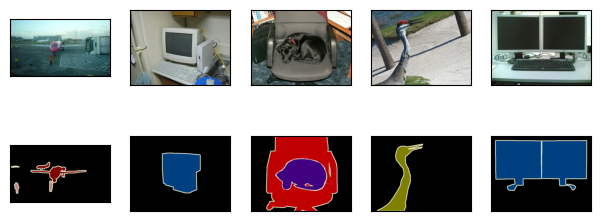

NameError: name 'Layer' is not defined

In [6]:
# Some helper functions to load and process the dataset
d2l.DATA_HUB["voc2012"] = (d2l.DATA_URL + "VOCtrainval_11-May-2012.tar", "4e443f8a2eca6b1dac8a6c57641b67dd40621a49")
if not os.path.exists("../data/VOCdevkit/VOC2012"):
    voc_dir = d2l.download_extract("voc2012")
else:
    voc_dir = "../data/VOCdevkit/VOC2012"

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


voc_dir = "../data/VOCdevkit/VOC2012"

def read_voc_image(file: str):
    """Read all VOC feature and label images."""
    image_binary = tf.io.read_file(os.path.join(
        voc_dir, 'JPEGImages', f'{file}.jpg'))
    image = tf.io.decode_jpeg(image_binary, channels=3)

    label_binary = tf.io.read_file(os.path.join(
        voc_dir, 'SegmentationClass', f'{file}.png'))
    label = tf.io.decode_png(label_binary, channels=3)

    return image, label


n = 5
x_train = []
y_train = []
for f_name in ("2007_000032", "2007_000039", "2007_000063", "2007_000068", "2007_000121"):
    sample_image, sample_label = read_voc_image(f_name)
    x_train.append(sample_image)
    y_train.append(sample_label)

d2l.show_images(x_train[:n] + y_train[:n], 2, n)
plt.show()

def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = np.zeros(256 ** 3, dtype=int)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

    return colormap2label


def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    label = colormap2label[idx]
    return label


def voc_label2colormap(label):
    return np.choose(label[..., np.newaxis], choices=VOC_COLORMAP)
class RandomCropModule(Layer):
    def __init__(self, crop_height, crop_width, **kwargs):
        super().__init__(**kwargs)
        crop_size = crop_height, crop_width
        self.random_crop_image = RandomCrop(*crop_size, seed=42)
        self.random_crop_label = RandomCrop(*crop_size, seed=42)
        self.augment_inputs = RandomFlip(mode="horizontal", seed=42)
        self.augment_labels = RandomFlip(mode="horizontal", seed=42)

    def call(self, inputs, *args, **kwargs):
        labels = args[0]
        image = self.random_crop_image(inputs[tf.newaxis, ...])
        image = self.augment_inputs(image)[0]
        label = self.random_crop_label(labels[tf.newaxis, :, :, tf.newaxis])
        label = self.augment_labels(label)[0, :, :, 0]
        return image, label


def load_voc(is_train: bool):
    file_names = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt')
    with open(file_names, 'r') as f:
        image_names = f.read().split()

    label_mapper = voc_colormap2label()
    random_crop = RandomCropModule(224, 224)

    for file in image_names:
        image, label_colormap = read_voc_image(file)
        label = voc_label_indices(label_colormap, label_mapper)
        image = image / 255
        label = tf.convert_to_tensor(label)
        if not is_train:
          img_crop = tf.image.resize(image, (224, 224))
          label_crop = tf.image.resize(label[..., tf.newaxis], (224, 224), method=ResizeMethod.NEAREST_NEIGHBOR)[:, :, 0]
          yield (img_crop, label_crop)
        else:
          if image.shape[0] >= 224 and image.shape[1] >= 224:
            img_crop, label_crop =  random_crop(image, label)
            yield (img_crop, label_crop)
          else:
            img_crop = tf.image.resize(image, (224, 224))
            label_crop = tf.image.resize(label[..., tf.newaxis], (224, 224), method=ResizeMethod.NEAREST_NEIGHBOR)[:, :, 0]
            yield (img_crop, label_crop)


def build_dataset(is_train: bool):
    return tf.data.Dataset.from_generator(load_voc, args=(is_train,),
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=((None, None, 3), (None, None)))

# The Initializer function to initialize the kerners of Transpose Conv2D layer
class BilinearKernelInitializer(Initializer):

    def __init__(self, out_channels, kernel_size):
        self.out_channels = out_channels
        self.kernel_size = kernel_size

    def __call__(self, shape, dtype=None, **kwargs):
        in_channels = shape[-1]
        factor = (self.kernel_size + 1) // 2
        if self.kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = (np.arange(self.kernel_size).reshape(-1, 1),
              np.arange(self.kernel_size).reshape(1, -1))
        filter_ = (1 - np.abs(og[0] - center) / factor) * \
                  (1 - np.abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, self.out_channels, self.kernel_size, self.kernel_size))
        weight[range(in_channels), range(self.out_channels)] = filter_
        return np.transpose(weight, (2, 3, 0, 1))


In [ ]:
bz_train = 32
bz_test = 32
NUM_CLASSES=21
train_dataset = build_dataset(is_train=True).shuffle(1000).batch(batch_size=bz_train).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = build_dataset(is_train=False).batch(batch_size=bz_test).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Calculate and return the MeanIoU score
def metric_mean_iou(model, dataset, num_classes=NUM_CLASSES):
  metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)
  dataset.shuffle(1000)
  iou_total = 0
  num_sample = 0
  for sample_images, sample_labels in dataset.take(100):
    bz = len(sample_images)
    pred = model.predict(sample_images, verbose=0)
    pred_max = tf.argmax(pred, axis=-1)
    iou_score_mean = metric(sample_labels, pred_max)
    iou_total += iou_score_mean*bz
    num_sample += bz
  score = iou_total/num_sample
  print("MeanIoU of", num_sample, "samples is", score)
  return score

# Task 1: Baseline FCN

#Task 2: Improve the baseline FCN

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Dropout, Concatenate, Input, Add, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

def conv_block(input, filters):
    x = Conv2D(filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def build_fcn_with_fpn(output_channels: int):
    # Load EfficientNetB0 model as backbone
    backbone = effnet

    layer1 = backbone.get_layer('input_1').output #224x224x3
    layer1 = conv_block(layer1, 42) # double number of channels
    layer1 = Dropout(0.1)(layer1)  # Adding dropout with a rate of 0.1 as specified in the paper

    layer3 = backbone.get_layer('block1a_activation').output #112x112x96
    layer4 = backbone.get_layer('block2a_activation').output #56x56x144
    layer5 = backbone.get_layer('block3a_activation').output #28x28x240
    layer6 = backbone.get_layer('block4a_activation').output #14x14x480
    layer7 = backbone.get_layer('block7a_activation').output #7x7x1280

    # Create the feature pyramid
    x = conv_block(layer7, 42)
    x = Add()([UpSampling2D(size=(2, 2))(x), conv_block(layer6, 42)])
    x = Add()([UpSampling2D(size=(2, 2))(x), conv_block(layer5, 42)])
    x = Add()([UpSampling2D(size=(2, 2))(x), conv_block(layer4, 42)])
    x = Add()([UpSampling2D(size=(2, 2))(x), conv_block(layer3, 42)])
    features = x

    # Add a final Conv2DTranspose layer to upsample the features to the original image size
    outputs = Conv2DTranspose(output_channels, kernel_size=(64, 64), strides=2, padding='same', activation='softmax')(features)

    # Construct the FCN model with FPN
    model = Model(inputs=backbone.inputs, outputs=outputs)

    return model

# Build the model
output_channels = 21  # Example for 21 classes
build_fcn_with_fpn = build_fcn_with_fpn(output_channels)

# Print model summary
build_fcn_with_fpn.summary()

import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class MeanIoUCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        mean_iou = metric_mean_iou(self.model, train_dataset)
        logs['mean_iou'] = mean_iou
        val_mean_iou = metric_mean_iou(self.model, val_dataset)
        logs['val_mean_iou'] = val_mean_iou

# Compile the model
optimizer = tf.keras.optimizers.Adam()
loss = 'sparse_categorical_crossentropy'
build_fcn_with_fpn.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model with MeanIoU callback
history3 = build_fcn_with_fpn.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[MeanIoUCallback()])


# Extract training history
accuracy = history_efficientNet_unet2.history['accuracy']
val_accuracy = history_efficientNet_unet2.history['val_accuracy']
loss = history_efficientNet_unet2.history['loss']
val_loss = history_efficientNet_unet2.history['val_loss']
mean_iou = history_efficientNet_unet2.history['mean_iou']
val_mean_iou = history_efficientNet_unet2.history['val_mean_iou']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(mean_iou, label='IoU Accuracy')
plt.plot(val_mean_iou, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU accuract')
plt.legend()
plt.show()